In [1]:
import math
import time
import matplotlib.pyplot as plt
import torch

from pytorch3d.structures import (
    Pointclouds,
    Meshes,
)

import torch
import torch.nn.functional as F
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.io import load_obj
from pytorch3d.structures import (
    Pointclouds,
    Meshes,
)
from pytorch3d.renderer.blending import BlendParams
from pytorch3d.renderer import TexturesVertex
from src.render.points_renderer import PointsRenderer
from src.render.pulsar_renderer import PulsarRenderer
from src.config import get_parser
from src.blueprint_sampler import BlueprintSampler
from src.util import grid_to_list

In [2]:
# Set the cuda device
device = torch.device("cuda:0")
torch.cuda.set_device(device)

bs = 1
    
config = get_parser().parse_args(args=[])

config.raster_image_size = 1024
config.data_blueprint = 'blueprint_radial_2048.npz'
config.data_blueprint_size = 2048
config.data_patch_size = 2048
blueprintSampler = BlueprintSampler(config)
res = blueprintSampler(bs)
points = res['points']
normals = res['normals']
faces = res['faces']

points = grid_to_list(points).to(device)
normals = grid_to_list(normals).to(device)
#faces = faces.to(device)

points.shape, normals.shape, faces.shape

(torch.Size([1, 4194304, 3]),
 torch.Size([1, 4194304, 3]),
 torch.Size([1, 8380418, 3]))

In [5]:
import trimesh

vertices = points[0].cpu().numpy()
faces = blueprintSampler.faces[0].cpu().numpy()
mesh = trimesh.Trimesh(vertices=vertices, 
                       faces=faces, 
                       process=False
                      )
#mesh.export('./face_tris1.stl');

In [6]:
vertex_normals = mesh.vertex_normals
vertex_normals = torch.tensor(vertex_normals.copy()).float().to(device)[None]
vertex_normals.shape

torch.Size([1, 4194304, 3])

In [76]:
# parser.add_argument('--raster_radius', type=float, default=0.01, 
#                     help='Points radius')
# parser.add_argument('--raster_points_per_pixel', type=int, default=4)
config.raster_image_size = 256
config.raster_radius = 0.005
config.raster_points_per_pixel = 1
config.raster_radius, config.raster_points_per_pixel

(0.005, 1)

In [77]:
R = PointsRenderer(config)
R.setup(device)
R = R.to(device)

0.2868478298187256


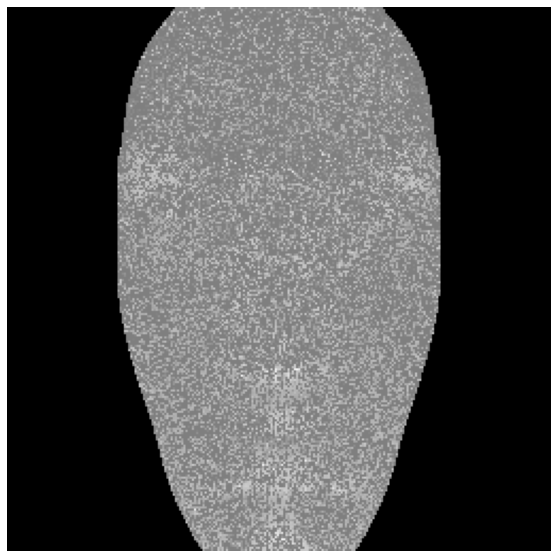

In [78]:
start_time = time.time()
images = R(points, normals=vertex_normals)
print(time.time() - start_time)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

0.2933635711669922


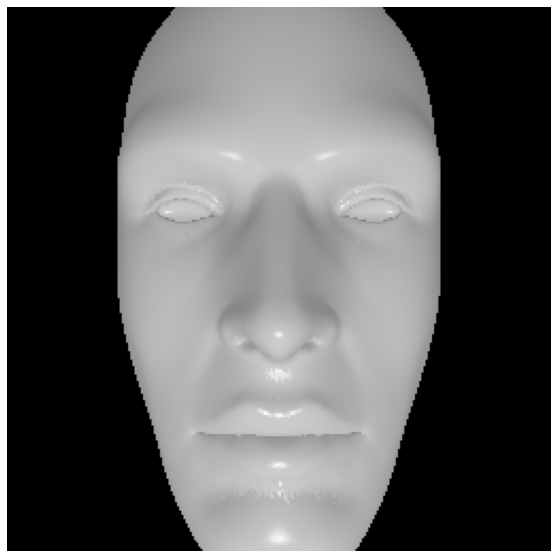

In [79]:
start_time = time.time()
images = R(points, normals=normals)
print(time.time() - start_time)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

In [6]:
cal_normals = R.vrt_nrm(points)
cal_normals

tensor([[[ 0.0000,  0.0000,  0.0000],
         [-0.8296, -0.5516,  0.0867],
         [ 0.8296,  0.5516, -0.0871],
         ...,
         [ 0.9949,  0.0498,  0.0874],
         [ 0.9954,  0.0558,  0.0784],
         [ 0.0000,  0.0000,  0.0000]]], device='cuda:0')

2.833139181137085


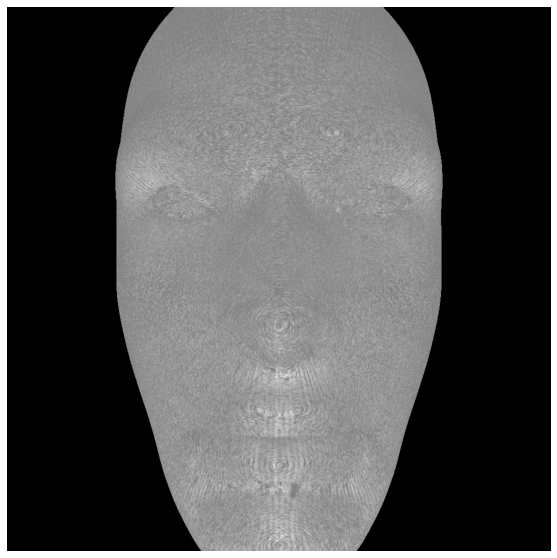

In [7]:
start_time = time.time()
images = R(points, normals=cal_normals)
print(time.time() - start_time)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

In [17]:
 def bicubic(t):
    res = F.interpolate(t.reshape(1, 2048, 2048, 3), 
                        scale_factor=1, mode='bicubic', 
                        align_corners=True)
    return res.reshape(1, -1, 3)
bic = bicubic(cal_normals)
torch.allclose(bic, cal_normals)

True

In [15]:
cal_normals

tensor([[[ 0.0000,  0.0000,  0.0000],
         [-0.8296, -0.5516,  0.0867],
         [ 0.8296,  0.5516, -0.0871],
         ...,
         [ 0.9949,  0.0498,  0.0874],
         [ 0.9954,  0.0558,  0.0784],
         [ 0.0000,  0.0000,  0.0000]]], device='cuda:0')

In [13]:
cal_normals.reshape(1, 2048, 2048, 3).shape

torch.Size([1, 2048, 2048, 3])

In [45]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import cv2
 
class GaussianBlurConv(nn.Module):
    def __init__(self, channels=3):
        super(GaussianBlurConv, self).__init__()
        self.channels = channels
        kernel = [[0.00078633, 0.00655965, 0.01330373, 0.00655965, 0.00078633],
                  [0.00655965, 0.05472157, 0.11098164, 0.05472157, 0.00655965],
                  [0.01330373, 0.11098164, 0.22508352, 0.11098164, 0.01330373],
                  [0.00655965, 0.05472157, 0.11098164, 0.05472157, 0.00655965],
                  [0.00078633, 0.00655965, 0.01330373, 0.00655965, 0.00078633]]
        kernel = torch.tensor(kernel)[None][None].expand(channels, channels, -1, -1)        
        self.weight = nn.Parameter(data=kernel, requires_grad=False)
 
    def __call__(self, x):
        x = F.conv2d(x, self.weight, padding=2, groups=1)
        return x

gaussian_conv = GaussianBlurConv().to(device)
gaussian_conv.weight.shape

torch.Size([3, 3, 5, 5])

In [47]:
g_blur = gaussian_conv(cal_normals.permute(0, 2, 1).reshape(1, 3, 2048, 2048))
g_blur.shape

torch.Size([1, 3, 2048, 2048])

In [48]:
blurred_normals  = g_blur.reshape(1, 3, -1).permute(0, 2, 1)
blurred_normals.shape

torch.Size([1, 4194304, 3])

tensor([[[-3.0463e-04, -3.0463e-04, -3.0463e-04],
         [-3.0242e-04, -3.0242e-04, -3.0242e-04],
         [-3.2454e-05, -3.2454e-05, -3.2454e-05],
         ...,
         [ 7.0363e-04,  7.0363e-04,  7.0363e-04],
         [ 6.1240e-04,  6.1240e-04,  6.1240e-04],
         [ 3.1331e-04,  3.1331e-04,  3.1331e-04]]], device='cuda:0')

2.787191152572632


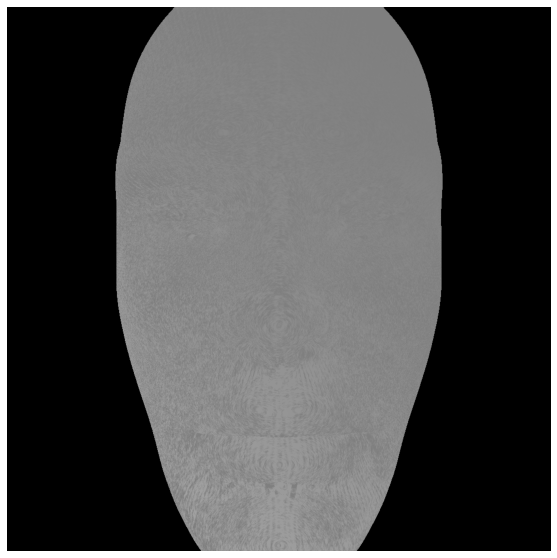

In [49]:
start_time = time.time()
images = R(points, normals=blurred_normals)
print(time.time() - start_time)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

2.8359854221343994


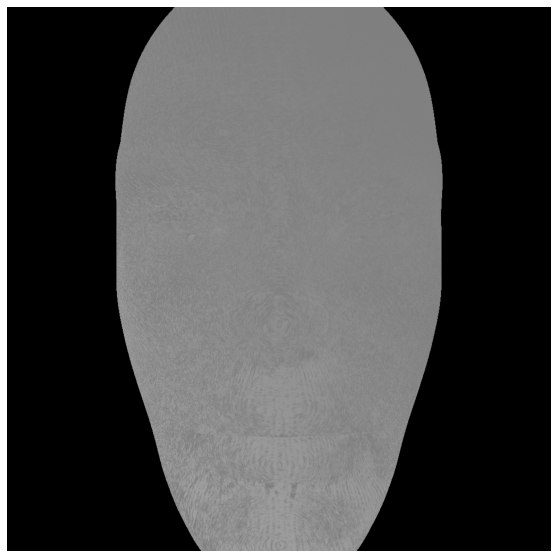

In [51]:
start_time = time.time()
images = R(points, normals=F.normalize(blurred_normals))
print(time.time() - start_time)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

In [40]:
conv = torch.nn.Conv2d(3, 3, kernel_size=5).to(device)
conv(cal_normals.permute(0, 2, 1).reshape(1, 3, 2048, 2048))

tensor([[[[ 0.2421, -0.3718, -0.2330,  ...,  0.0154, -0.2732,  0.1944],
          [ 0.1430, -0.2358, -0.3600,  ..., -0.0899,  0.3099,  0.2363],
          [ 0.1366,  0.1680,  0.1874,  ..., -0.0272, -0.1107,  0.0156],
          ...,
          [ 0.0035,  0.1785, -0.0280,  ...,  0.0386, -0.0387, -0.0327],
          [ 0.0275,  0.3249, -0.0191,  ..., -0.6465, -0.3445,  0.0357],
          [ 0.1509,  0.1742, -0.0857,  ...,  0.1459,  0.0189, -0.0153]],

         [[ 0.0379,  0.1017,  0.2002,  ...,  0.4281,  0.1097, -0.0844],
          [-0.3092, -0.4085, -0.1185,  ...,  0.1513,  0.1850,  0.1510],
          [ 0.6604,  0.2974,  0.3112,  ..., -0.0784,  0.2713, -0.2433],
          ...,
          [ 0.1468, -0.1587, -0.4230,  ...,  0.0965,  0.4723,  0.4972],
          [ 0.0772, -0.3279, -0.3859,  ...,  0.5265,  0.1744,  0.2601],
          [-0.0066, -0.0493,  0.0322,  ...,  0.8028,  0.4963,  0.2042]],

         [[ 0.1537,  0.2422, -0.0828,  ..., -0.1533,  0.0724, -0.0700],
          [ 0.6133, -0.0641, -

In [28]:
conv.weight.shape

torch.Size([3, 3, 5, 5])

In [32]:
kernel = [[0.00078633, 0.00655965, 0.01330373, 0.00655965, 0.00078633],
                  [0.00655965, 0.05472157, 0.11098164, 0.05472157, 0.00655965],
                  [0.01330373, 0.11098164, 0.22508352, 0.11098164, 0.01330373],
                  [0.00655965, 0.05472157, 0.11098164, 0.05472157, 0.00655965],
                  [0.00078633, 0.00655965, 0.01330373, 0.00655965, 0.00078633]]
kernel = torch.tensor(kernel)[None][None].expand(3, 3, -1, -1)
kernel.shape

torch.Size([3, 3, 5, 5])

In [58]:
points.shape, blueprintSampler.faces.shape

(torch.Size([1, 4194304, 3]), torch.Size([1, 8380418, 3]))